In [4]:
from os import listdir

import pandas as pd
import numpy as np
import scipy.stats as stats

import math

import statsmodels.formula.api as sm
import statsmodels.api as smstats
from statsmodels.tools.tools import add_constant

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks", color_codes=True)
sns.set_context('notebook')
sns.set_style('darkgrid')

In [5]:
xl = pd.ExcelFile('Multivariate_Data_Analysis_6e_Datasets_EXCEL.xls')

In [6]:
xl.sheet_names

['HBAT',
 'HBAT_200',
 'HBAT_MISSING',
 'HBAT_SPLITS',
 'HBAT_CPLAN',
 'HBAT_CONJOINT',
 'HBAT_MDS',
 'HBAT_CORRESP',
 'HBAT_SEM',
 'HBAT_SEM_NOMISSING',
 'HATCO',
 'SALES']

In [7]:
df = xl.parse('HBAT')

In [8]:
def generate_heatmap(df, title = ''):
    ## heatmeap to see the correlation between features. 
    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(df.corr())
    #mask[np.triu_indices_from(mask)] = True

    plt.subplots(figsize = (24,16))
    plt.subplots_adjust(top=0.90)
    sns.heatmap(df.corr(), 
                annot=True,
                #mask = mask,
                cmap = 'RdBu_r',
                linewidths=0.1, 
                linecolor='white',
                vmax = 1,
                square=True,
               fmt='.3f')
    plt.title(title, y = 1.03,fontsize = 20);

In [9]:
dependent_var = 'X19'

# Independent variables:
cols = ['X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']
col_names = {
    'X6': 'Product Quality X6',
    'X7': 'E-Commerce X7',
    'X8': 'Technical Support X8',
    'X9': 'Complaint Resolution X9',
    'X10': 'Advertising X10',
    'X11': 'Product Line X11',
    'X12': 'Salesforce Image X12',
    'X13': 'Competitive Pricing X13',
    'X14': 'Warranty & Claims X14',
    'X15': 'New Products X15',
    'X16': 'Order & Billing X16',
    'X17': 'Price Flexibility X17',
    'X18': 'Delivery Speed X18',
    'X19': 'Customer Satisfaction X19'
}

corr_cols = cols.copy()
corr_cols.insert(0, dependent_var)
corr_df = df[corr_cols]

summary_columns = pd.MultiIndex.from_tuples([
        ('', 'Step'),
        ('', 'Var.'),
        ('Overall Model Fit', 'R'),
        ('Overall Model Fit', 'Rˆ2'),
        ('Overall Model Fit', 'Adjusted Rˆ2'),
        ('Overall Model Fit', 'Std. Error of the Estimate'),
        ('Rˆ2 Change Statistics','Rˆ2 Change'),
        ('Rˆ2 Change Statistics','F Value of Rˆ2 Change'),
        ('Rˆ2 Change Statistics','df1'),
        ('Rˆ2 Change Statistics','df2'),
        ('Rˆ2 Change Statistics','Significance of Rˆ2 Change'),
    ])

model_summary = pd.DataFrame(columns=summary_columns)

model_summary

Empty DataFrame
Columns: [(, Step), (, Var.), (Overall Model Fit, R), (Overall Model Fit, Rˆ2), (Overall Model Fit, Adjusted Rˆ2), (Overall Model Fit, Std. Error of the Estimate), (Rˆ2 Change Statistics, Rˆ2 Change), (Rˆ2 Change Statistics, F Value of Rˆ2 Change), (Rˆ2 Change Statistics, df1), (Rˆ2 Change Statistics, df2), (Rˆ2 Change Statistics, Significance of Rˆ2 Change)]
Index: []

### Model Summary of Stepwise Multiple Regression Model

In [10]:
#FIXME - "stde_est" It should be passed as argument
#FIXME - "model_summary" should not be global
#TODO FIXME - F Value of Rˆ2 Change

def update_model_summary(OLSResults, vars_entered_into_rm, ve):
    
    #Overall Model Fit
    r = round(math.sqrt(OLSResults.rsquared),3)
    rsquared = round(OLSResults.rsquared,3)
    rsquared_adj = round(OLSResults.rsquared_adj,3)

    #Rˆ2 Change Statistics
    step = model_summary.shape[0]+1
    if step > 1:
        previous_rsquared = model_summary.loc[step-1]['Overall Model Fit']['Rˆ2']
        r2_change = round((rsquared - previous_rsquared),3)
    else:
        r2_change = round(rsquared,3)
        
    f_value_r2_change = round(OLSResults.fvalue,3) #FIXME
    df1 = OLSResults.df_model
    df2 = OLSResults.df_resid
    sign_of_r2_change = vars_entered_into_rm.loc[ve]['P>|t|']

    model_summary.loc[step] = (step,ve,r,rsquared,rsquared_adj, round(stde_est, 3), r2_change, f_value_r2_change, df1, df2, sign_of_r2_change)
    
model_summary    

Empty DataFrame
Columns: [(, Step), (, Var.), (Overall Model Fit, R), (Overall Model Fit, Rˆ2), (Overall Model Fit, Adjusted Rˆ2), (Overall Model Fit, Std. Error of the Estimate), (Rˆ2 Change Statistics, Rˆ2 Change), (Rˆ2 Change Statistics, F Value of Rˆ2 Change), (Rˆ2 Change Statistics, df1), (Rˆ2 Change Statistics, df2), (Rˆ2 Change Statistics, Significance of Rˆ2 Change)]
Index: []

### Colinearity diagnosis (Tolerance and VIF)

In [11]:
def vif_calc(x_vars):
    vif_tol = pd.DataFrame(columns=['Tolerance', 'VIF'])

    xvar_names = x_vars.columns
    for col in xvar_names:
        y = x_vars[col] 
        x = x_vars[xvar_names.drop(col)]
        x = add_constant(x)

        rsq = sm.OLS(y,x).fit().rsquared  
        
        vif = round(1/(1-rsq),3)
        tolerancy = round(1-rsq, 3)

        vif_tol.loc[col] = (tolerancy, vif)
        
    return vif_tol

### OLS (Ordinary Least Squares Model)

In [12]:
def OLS(y,x):
    df = corr_df.copy()
    X = df[x]; 
    y = df[y]
    
    X = add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    
    return results

### Variables Entered the into Regression Model

In [13]:
def variables_entered(dependent_var, varse):
    df = corr_df.copy()
    
    results = OLS(dependent_var, varse)
    vif_tol = vif_calc(df[varse])

    rs = results.summary()

    '''Note that tables is a list. The table at index 1 is the "core" table. 
       Additionally, read_html puts dfs in a list, so we want index 0
    '''
    results_as_html = rs.tables[1].as_html()
    table1 = pd.read_html(results_as_html, header=0, index_col=0)[0]

    return pd.concat([table1,vif_tol], axis=1, join='inner')

### ANOVA

In [14]:
def anova(y, varse):
    df = corr_df.copy()
    X = add_constant(df)
    formula = y + '~' + '+'.join(varse)
    mod = sm.ols(formula, data=X).fit()
    
    aov_table = smstats.stats.anova_lm(mod, typ=2)
    aov_table = round(aov_table,3)
    
    return aov_table

In [15]:
# infl = results.get_influence()
# df_infl = infl.summary_frame()
# round(df_infl[:5],3)

### Partial correlation
- First order
![title](first_order.png)
- High order
![title](high_order.png)

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

columns = pd.MultiIndex.from_tuples([
        ('', 'Beta In'),
        ('Statistical Significance', 't-value'), ('Statistical Significance', 'Significance'),
        ('', 'Partial Correlation'),
        ('Collinearity Statistics', 'Tolerance'),('Collinearity Statistics', 'VIF')
    ])

zero_order_corr = corr_df.corr()

def calc_abc(ab,ac,bc):
    return (ab-ac*bc) / (np.sqrt(1-pow(ac, 2)) * np.sqrt(1-pow(bc, 2)))

def first_order(a, b, c):
    ra = zero_order_corr.loc[a,b] 
    rb = zero_order_corr.loc[a,c] 
    rc = zero_order_corr.loc[b,c]

    return calc_abc(ra,rb,rc)

def partial_correlation(j,k,p,varse):
    if(len(varse)==1):
        return first_order(j,k,p)
    
    return calc_abc(
        partial_correlation(j, k, varse[-2], varse[:-1]),
        partial_correlation(j, varse[-1], varse[-2], varse[:-1]),
        partial_correlation(k, varse[-1], varse[-2], varse[:-1])
    )

def partial_correlations(j, k, varse):
    rjkp = partial_correlation(j, k, varse[0], varse.copy())

    return round(rjkp,3)

def vif_in(X, v):  
    p = pd.Series(variance_inflation_factor(X.values, 1), index=X.columns)

    vif = p[v]
    tolerance = 1/vif
    
    return (round(tolerance,3), round(vif,3))

def beta_stats_sign(Y, X, k):
    df = corr_df.copy()
    
    model = sm.OLS(Y, X)
    result = model.fit()

    #beta
    beta_in = result.params[k]

    #t, p-value, dof
    t = result.tvalues[k]
    p = result.pvalues[k]
    dof = df.shape[0]-2
    significance = stats.t.sf(abs(t), dof)*2

    return (round(beta_in,3), round(t,3), round(significance,3))

def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    if(s.name[1] in ['Significance', 'VIF']):
        is_min = s == s.min() 

        return ['background-color: yellow' if v else '' for v in is_min]
    else:
        is_max = s == s.max()
        
        return ['background-color: yellow' if v else '' for v in is_max]

def variables_not_entered_int_rm(y, varse):
    df = corr_df.copy()
    
    stats_sign = pd.DataFrame(columns=columns)
    
    # standardizing dataframe
    df_z = df.select_dtypes(include=[np.number]).dropna().apply(stats.zscore)
    
    for k in df_z.columns:
        if(k == y or k in varse):
            continue   
            
        Y = df_z[y]
        X = add_constant(df_z[[k]+varse])
        
        #Beta and Statistical significance
        beta_in, t, sig = beta_stats_sign(Y,X,k)
        
        #Tolerance, Vif
        tolerance,vif = vif_in(X, k)
        
        #Partial correlation
        partial_correlation = partial_correlations(y, k, varse)

        stats_sign.loc[col_names[k]] = (beta_in,t,sig, partial_correlation, tolerance, vif)
        
    return stats_sign.style.apply(highlight_max)

In [17]:
# r12 = .603 #X19 and X9
# r13 = .486 #X19 and X6
# r23 = .106 #X9 and X6

# partial = (r12-r13*r23) / (np.sqrt(1-pow(r13, 2)) * np.sqrt(1-pow(r23, 2)))
# print("X9 partial: ", round(partial, 3))

In [18]:
# x9_semipartial_corr = (r12-r13*r23) / np.sqrt(1-pow(r23, 2))
# x9_semipartial_corr = round(x9_semipartial_corr, 3)
# print("Semipartial of X9 and X19 with X6 controlled: ", x9_semipartial_corr)
# print("Unique variance previewd X9: ", round(pow(x9_semipartial_corr, 2),3) )

In [19]:
# x6_semipartial_corr = (r12-r13*r23) / np.sqrt(1-pow(r13, 2))

# x6_semipartial_corr = round(x6_semipartial_corr, 3)
# print("Semipartial of X6 and X19 with X9 controlled: ", x6_semipartial_corr)
# print("Unique variance previewd X6: ", round(pow(x6_semipartial_corr, 2),3) )


In [20]:
# listdir()

![title](data_dictionary.png)

In [21]:
df.head(5)

,ID,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23
0,1,2,0,1,1,1,8.5,3.9,2.5,5.9,...,4.7,4.3,5.0,5.1,3.7,8.2,8.0,8.4,65.1,1
1,2,3,1,0,0,0,8.2,2.7,5.1,7.2,...,5.5,4.0,3.9,4.3,4.9,5.7,6.5,7.5,67.1,0
2,3,3,0,1,1,1,9.2,3.4,5.6,5.6,...,6.2,4.6,5.4,4.0,4.5,8.9,8.4,9.0,72.1,1
3,4,1,1,1,1,0,6.4,3.3,7.0,3.7,...,7.0,3.6,4.3,4.1,3.0,4.8,6.0,7.2,40.1,0
4,5,2,0,1,0,1,9.0,3.4,5.2,4.6,...,6.1,4.5,4.5,3.5,3.5,7.1,6.6,9.0,57.1,0


![title](stage1_3.png)

# Stage 1: Objectives of Multiple Regression 

The following 13 variables were included as independent variables:

We selecte **Customer Satisfaction (X19)** as the dependent variable **(Y)** to predicted by independent variables. 

The relationship among the 13 independent variables and customer satisfaction was assumed to be statistical, not functional, because it involved perceptions of performance and may include levels of measurement error.

![title](variables.png)

# Stage 2: Research Design of a Multiple Regression Analysis

- The first question to be answered concerning sample size is the level of relationship **(Rˆ2)** that can be detected reliably with the proposed regression analysis. 

- Table 5 indicates that the sample of 100, with 13 potential independent variables, is able to detect relationships with Rˆ2 values of approximately **23%** at power of **.80** with the significance level set at **.01**. If the significance level is relaxed to **.05**, then the analysis will identify relationships explaining about **18%** of the variance. 

- The sample of 100 observartions also meets the guideline for the minimum ratio of observations to indepent variables (**5:1**) with an actual ratio of **7:1** (100 observations with 13 variables)

    The proposed regression analysis was deemed sufficient to identify not only statistically significant relationships but also relationships that had managerial significance

![title](minimum_r2.png)

# Stage 3: Assumptions in Multiple Regression Analysis

Analysis to ensure the research is meeting the basic assumptions of regression analysis involves two steps:

    1 - Testing the individual dependent and independent variables
    2 - Testing the overall relationship after model estimation.

# Stage 3.1.1 - Scatterplots to verify non-linear relationships

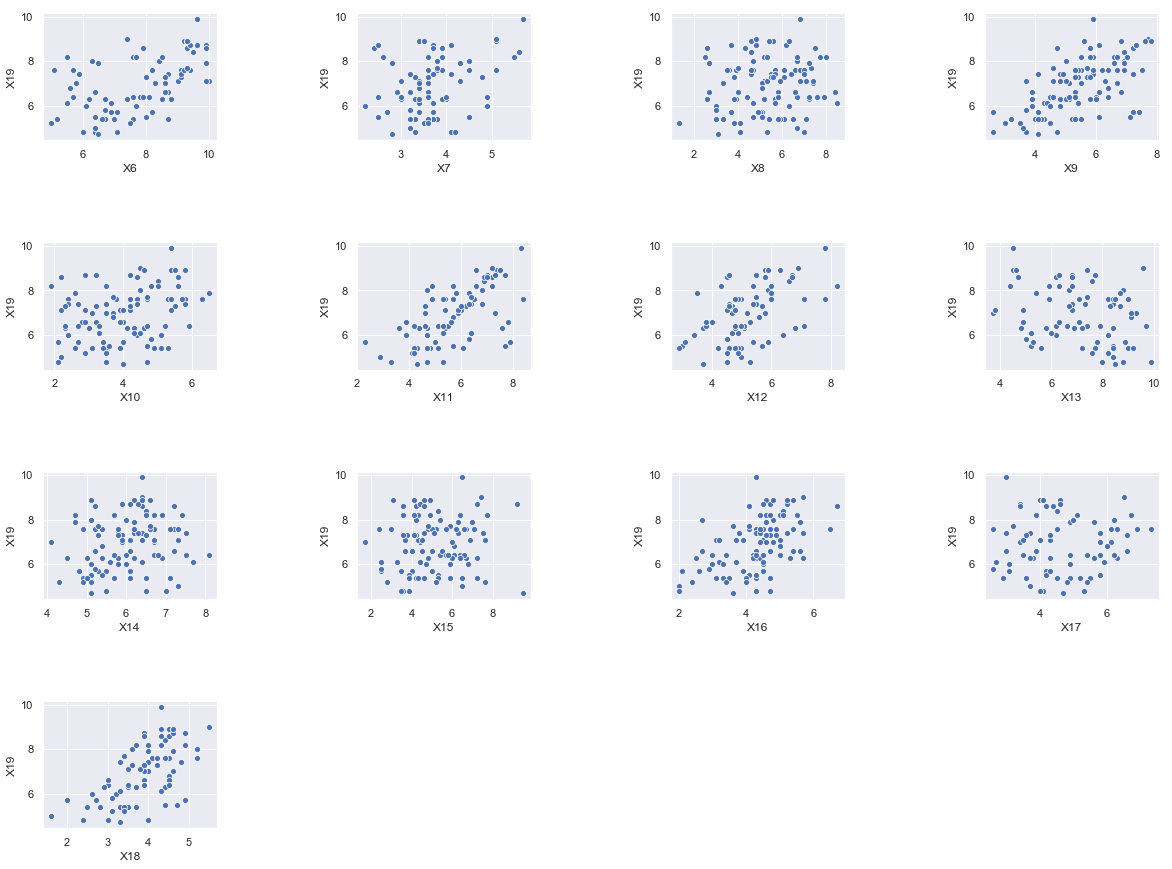

In [ ]:
fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(hspace=0.8, wspace=0.8)

for idx, col in enumerate(cols):
    ax = fig.add_subplot(4, 4, idx+1)
    sns.scatterplot(x = corr_df[col], y=corr_df[dependent_var], ax=ax)

- Scatterplots of the individual variables did not indicate any nonlinear relationships between the dependent **(X19)** and the independent variables

# Stage 3.1.1 -  Checking normality

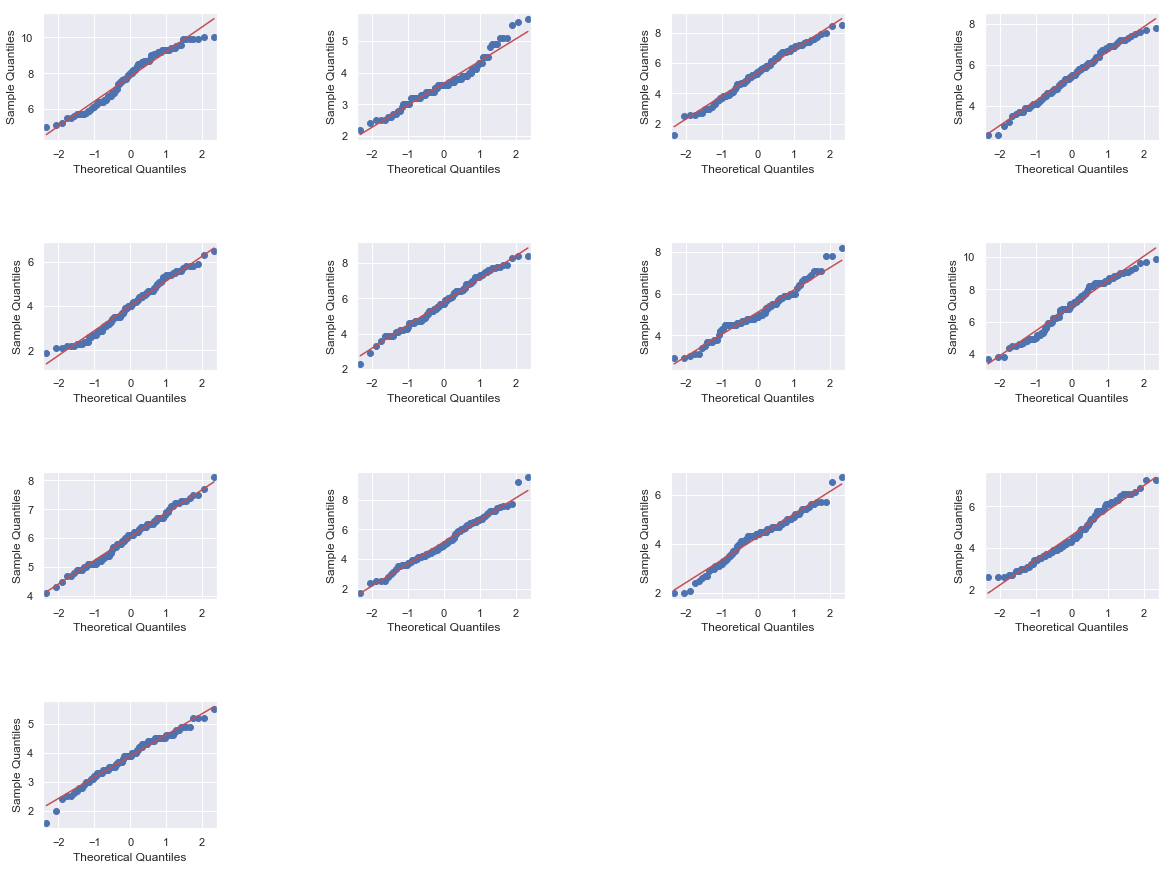

In [ ]:
from statsmodels.graphics.gofplots import qqplot
fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(hspace=0.8, wspace=0.8)

for idx, col in enumerate(cols):
    ax = fig.add_subplot(4, 4, idx+1)
    qqplot(df[col], line='s', ax=ax)

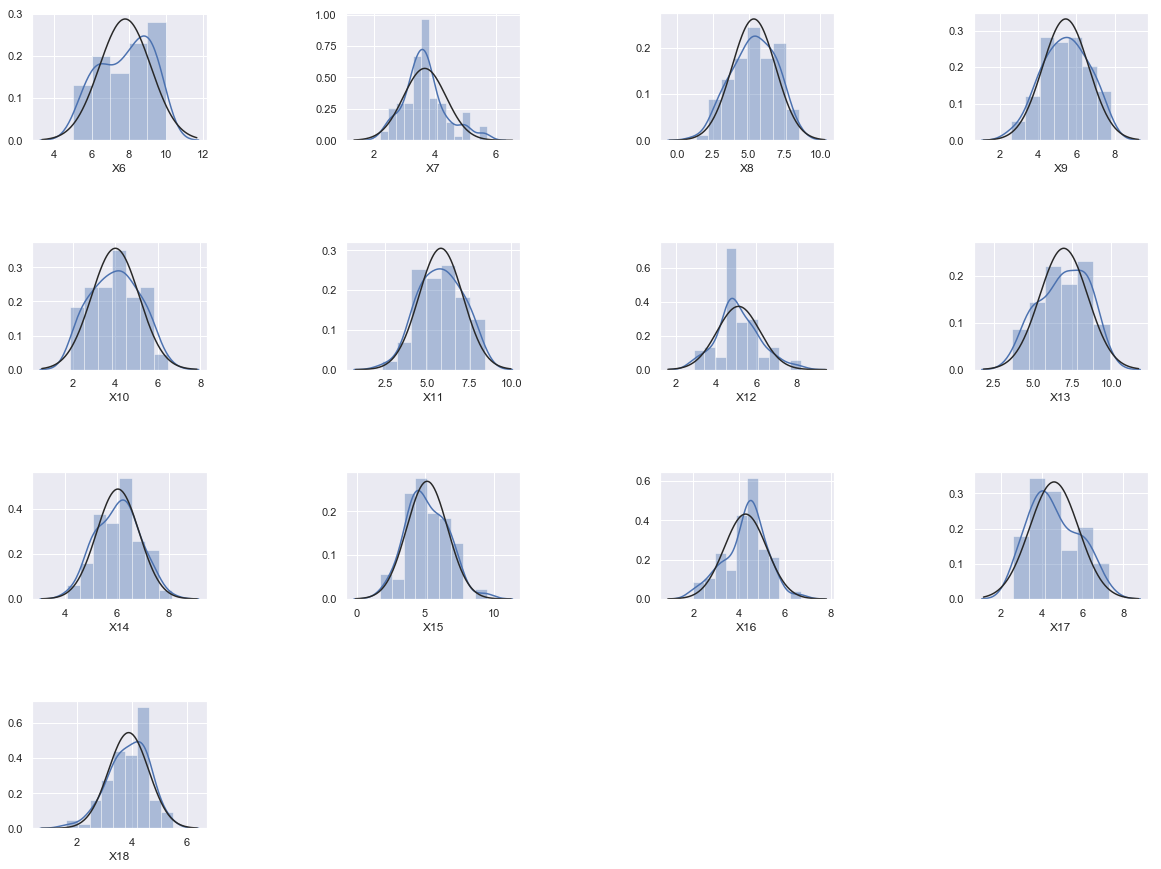

In [ ]:
fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(hspace=0.8, wspace=0.8)

for idx, col in enumerate(cols):
    ax = fig.add_subplot(4, 4, idx+1)
    sns.distplot(df[col], fit=stats.norm, ax=ax);
    stats.probplot(df[col])    
    

- ### skewness and kurtosis

In [ ]:
sk = pd.DataFrame(columns=['Skewness', 'Kurtosis'], index=cols)
for col in cols:
    #print("{}".format(first, second))
    skewness = corr_df[col].skew()
    kurtosis = corr_df[col].kurt()
    sk.loc[col] = (round(skewness,3),round(kurtosis,3))
sk

,Skewness,Kurtosis
X6,-0.245,-1.132
X7,0.66,0.735
X8,-0.203,-0.548
X9,-0.136,-0.586
X10,0.044,-0.888
X11,-0.092,-0.522
X12,0.377,0.41
X13,-0.24,-0.903
X14,0.008,-0.445
X15,0.299,0.016


- Six variables were found to violate the statistical tests
    * **X6** 
    * **X7**
    * **X12**
    * **X13**
    * **X16**
    * **X17**
    
- For all, except one **(X12)**, transformations were sufficient remedies.

# Stage 3.1.2 - Checking heteroscedasticity

In [ ]:
for idx, col in enumerate(cols):
    sns.jointplot(x=corr_df[col], y=corr_df[dependent_var], kind='reg')

* Only two variables **(X6 and X17)** had minimal violations of this assumption, with no corrective action needed

* Although regression analysis has been shown to be quite robust even when the normality assumption is violated, researches should estimate the regression analysis with both the original and transformed variables to assess the consequences of nonnormality of the independent variables on the interpretation of the results. 

* Here we use the original variables and later results for the transformed variables are shown for comparison

![title](stage4_6.png)

# Stage 4: Estimating the Regression Model and Assessing Overall Model Fit

- With the regression analysis specified in terms of dependent and independent variables, the sample deemeded adequate for the objectives of the study, and the assumptions assessed for the individual variables, the model-building process now proceeds to estimation of the regression model and assessing the overall model fit.

- For purposes of illustration, the stepwise procedure is employed to select variables for inclusion in the regression variable

![title](stepwise_estimation.png)

### Stepwise estimation: Selecting the first variable

- The stepwise estimation procedure maximizes the incremental **explained variance** at each step of model building.
- In the first step, the **highest bivariate correlation** (also the **highest partial correlation**, because no other variable are in the equation) will be selected

In [ ]:
generate_heatmap(corr_df)

- Examination of the correlation matrix reveals that **compaint resolution (X9)** has the highest bivariate correlation with the dependent variable **X19** (**0,603**). 
- The first step is to build a regression equation using just this single independent variable

In [ ]:
varse = ['X9']

In [ ]:
results = OLS(dependent_var, varse)
results.summary().tables[0]

In [ ]:
stde_est = np.sqrt(results.ssr / results.df_resid)

In [ ]:
anova(dependent_var, varse)

In [ ]:
vars_entered_into_rm = variables_entered(dependent_var, varse)    
vars_entered_into_rm

In [ ]:
update_model_summary(results, vars_entered_into_rm, 'X9')
model_summary

##  Variables Entered into the Regression Model

- **Multiple R** is the correlation  coefficient (at this step) for the simple regression of **X9 and X19**. It has no plus or minus sign because in multiple regression the signs of the individual variables may vary, so this coefficient reflects only the degree of association. In the first step of the stepwise estimation, the Multiple R is the same as the bivariate correlation (**.603**) because the equation contains only one variable
- **R-squared** is the correlation coefficient squared (**.603ˆ2 = .364**), also referred to as the *coefficient of determination*. This value indicates the percentage of total variation of Y (*X19, Customer Satisfaction*) explained by the regression model consisting of **X9**
- **Standard Error of the Estimate** is another measure of the accuracy of our predictions. It is the **sqrt(sum_sq)/df**, also represented by the sqrt of the ***MSresidual***. 
    - It represents an estimate of the standard deviation of the actual dependent values around the regression line; that is, it is a measure of variation around the regression line. Also can be viewed as the standard deviation of the prediction errors; thus it becomes a measure to assess the absolute size of the prediction error. It is used also in estimating the size of the confidence interval for the predictions
- ***ANOVA and F Ratio***  The *ANOVA* analysis provides the statistical test for the overall model fit in terms of the *F ratio*. 
    - The total sum of squares is the squared error that would ocurr if we used only the mean of Y to predict the dependent variable. Using the values of *X9* reduces this error by **36.4 percent** (51.178/140.628). This reduction is deemed statistically significant with an ***F ratio*** of **56.070** and a **significance level of .000**    

- **Variables in the Equation (Step 1)** In step 1, a single independent variable **(X9)** is used to calculate the regression equation for prediction the dependent variable. For each variable in the equation, several measures need to be defined: 
    - **The regression coefficient (b)**: Reflect the change in the dependent measure for each unit change in the Y. Comparison between regression coefficients allows for a relative assessment of each variable's importance in the regression model. The value **.595** is the regression coefficient *(**b9**)* for the **Y (X9)**. The predicted value for each observation in the intercept **(*Y* = 3.680 + .595X9)**.
    
    - **The standard error of the coefficient**: In a simple sense, it is the standard deviation of the estimates of ***b9*** across multiple samples. A smaller standard error implies more reliable prediction and therefore smaller confidence intervals. 
        - The standard error of ***b9*** is **.079**, denoting that the **95%** confidence interval for ***b9*** would be **.595 ± (1.96 x .079)**, or ranging from a low of **.44** to a high of **.75**. 
        - The value of ***b9*** divided by the standard error **(.595/.079 = 7.488)** is the calculated ***t*** value for a ***t-test*** of the hypothesis ***b9* = 0**
    - **The *t* value of variables in the Equation**: as just calculated, measures the significance of the partial correlation of the variable reflected in the regression coefficient. As such, it indicates whether the researcher can confidently say, with a stated level of error, that the coefficient is not equal to zero. ***F*** values may be given at this stage rather than ***t*** values.
        - They are directly comparable beacause the ***t*** value is approximately the square root of the ***F value***.
        - Is also particularly useful in the stepwise procedure in helping to determine whether any variable should be dropped from the equation once another independent variable has been added. The calculated level of significance is compared to the threshold level set by the researcher for dropping the variable. In our example, we set a **.10** level for dropping variables from the equation. 
        - The critical value for a significance level of **.10** with **98 df** is **1.658**. As more variables are added to the regression equation, each variable is checked to see whether it still falls within this threshold. If it falls outside the threshold (**significance > .10**), it is eliminanted from the regression equation, and the model is estimated again
        - In our example, the ***t*** value (as derived by dividing the regression coefficient by the standard error) is **7.488**, which is statistically significant at the **.000** level. It gives the researcher a high level of assurance that the coefficient is not equal to zero and can be assessed as a predictor of customer satisfaction.
        
    - ***Correlations*** Three different correlations are given as an aid in evaluating the estimation process. 
        - The ***zero-order*** correlation is the simple bivariate correlation between the independent and dependent variable. 
        - The ***partial correlation*** denotes the incremental predictive effect, controlling for other variables in the regression model on both dependent and independent variables. This measure is used for judging which variable is next added in sequential search methods. 
        - Finally, the ***part correlation*** denotes the unique effect attributable to each independent variable.
        - For the first step in a stepwise solution, all three correlations are identical (**.603**) because no other variables are in the equation. As variables are added, these values will differ, each reflecting their perspective on each independent variable’s contribution to the regression model.    
    - **The collinearity diagnosis (tolerance and VIF):** provide a perspective on the impact of collinearity on the independent variables in the regression equation. In the case of a single variable in the regression model, the tolerance is **1.00**, indicating that it is totally unaffected by other independent variables (as it should be since it is the only variable in the model). Also, the VIF is **1.00**. Both values indicate a complete lack of multicollinearity.

###  Variables Not Entered into the Regression Model

In [ ]:
vars_notent_into_rm = variables_not_entered_int_rm(dependent_var, varse)
vars_notent_into_rm

###  Variables Not Entered into the Regression Model

- With *X9* included in the regression equation, 12 other potential independent variables remain for inclusion to improve the prediction of the dependent variable. For each of these variables, four types of measures are available to assess their potential contribution to the regression model:
    
    - **Partial correlations and Collinearity Measures**: is a measure of the variation in Y that can be accounted for by each of these additional variables, controlloing for the variables already in the equation (only *X9* in step 1). If the variable with the highest partial correlation exceeds the threshold of statistical significance required for inclusion, it will be added to the regression model at the next step. The partial correlation represents the correlation of each variable in the model with the unexplained portion of dependent variable. As such, the contribution of the partial correlation (the squared partial correlation) is that percentage of the unexplained variance that is explained by the addicion of this independent variable. 
    
    It is interesting to note, however, that
        - ***X6*** had only the **sixth highest bivariate** correlation with *X19*. Why was it the second variable to enter the stepwise equation, ahead of the variables with higher correlations? 
        - The variables with the **second highest correlations with X19** were ***X18*** (**.577**), 
        - **Third**, ***X11*** (**.551**) 
        - **Fourth**, ***X16*** (**.522**) 
        - Both *X18* and *X16* had high correlations with X9, reflected in their rather low tolerance values of .252 and .427, respectively. It should be noted that this fairly high level of multicollinearity is not unexpected, because these three variables (X9, X16, and X18) constituted the first factor that would be derived in a first factor analysis (not performed here). X11, even though it does not join this factor, is highly correlated with X9 (.561) to the extent that the tolerance is only .685. 
        - Finally, ***X12***, the **fifth highest bivariate** correlation with X19, only has a correlation with X9 of **.230**, but it was just enough to make the partial correlation slightly lower than that of X6. The correlation of X9 and X6 of only **.106** resulted in a tolerance of **.989** and transformed the bivariate correlation of **.486** into a partial correlation of **.532**, which was highest among all the remaining 12 variables.
        
        If *X6* is added, then the R2 value should increase by the partial correlation squared times the amount of unexplained variance **(change in R2 = .532ˆ2 * .636 = .180)**. Because **36.4** percent was already explained by *X9*, *X6* can explain only **18.0** percent of the remaining variance. 
    
    - **Standardized coefficients (Beta)** 
        - We see that ***X6***, the variable with the highest partial correlation, also has the highest Beta coefficient if entered. Even though the magnitude of **.427** is substantial, it can also be compared with the beta for the variable now in the model (***X9*** with a **beta** of **.603**), indicating that *X6* will make a substantive contribution to the explanation of the regression model, as well as to its predictive capability.
    
    - ***t* values** The *t* value measures the significance of the partial correlations for variables not in the equation. They are calculated as a ratio of the additional sum of squares explained by including a particular variable and the sum of squares left after adding that same variable. If this t value does not exceed a specified significance level (e.g., .05), the variable will not be allowed to enter the equation.
        
        - We note that six variables *(X6, X7, X10, X11, X12, and X17)* exceed this value and are candidates for inclusion. Although all are significant, the variable added will be that variable with the highest partial correlation. We should note that establishing the threshold of statistical significance before a variable is added precludes adding variables with no significance even though they increase the overall R2.


**Looking Ahead** With the first step of the stepwise procedure completed, the final task is to evaluate the variables not in the equation and determine whether another variable meets the criteria and can be added to the regression model. As noted earlier, the partial correlation must be great enough to be statistically significant at the specified level (generally .05). If two or more variables meet this criterion, then the variable with the highest partial correlation is selected.

As described earlier, **X6 (Product Quality**) has the highest partial correlation at this stage, even though four other variables had higher bivariate correlations with the dependent variable. In each instance, multicollinearity with X9, entered in the first step, caused the partial correlations to decrease below that of X6.

We know that a significant portion of the variance in the dependent variable is explained by X9, but the stepwise procedure indicates that if we add X6 with the highest partial correlation coeffi- cient with the dependent variable and a ***t value*** is **significant at the .05 level**, we will make a significant increase in the predictive power of the overall regression model. Thus, we can now look at the new model using both X9 and X6.

### Stepwise estimation: Selecting the second variable (X6)

The next step in a stepwise estimation is to check and delete any of the variables in the equation that now fall below the significance threshold, and once done, add the variable with the **highest statistically significant partial correlation**.

In [ ]:
varse.append('X6')

In [ ]:
results = OLS(dependent_var, varse)
results.summary().tables[0]

In [ ]:
stde_est = np.sqrt(results.ssr / results.df_resid)

In [ ]:
anova(dependent_var, varse)

In [ ]:
vars_entered_into_rm = variables_entered(dependent_var, varse)    
vars_entered_into_rm

- **Estimated Coefficients** 
    - The beta weight is **.427**. 
    - Although not as large as the beta for X9 **(.558)**, X6 still has a substantial impact in the overall regression model. 
    - The coefficient is statistically significant and multicollinearity is minimal with X9 (as described in the earlier section). 
    - Thus, tolerance is quite acceptable with a value of **.989** indicating that only **1.1** percent of either variable is explained by the other.
    
    
- **Impact of Multicollinearity** The lack of multicollinearity results in little change for either the value of b9 **(.550)** or the beta of X9 **(.558)** in step 1. It further indicates that variables X9 and X6 are relatively independent (the simple correlation between the two variables is **.106**). If the effect of X6 on Y were totally independent of the effect of X9, the b9 coefficient would not change at all. 
    - The ***t values*** indicate that both X9 and X6 are statistically significant predictors of Y. 
    - The ***t value*** for X9 is now **8.092**, whereas it was **7.488** in step 1. 
    - The ***t value*** for X6 relates to the contribution of this variable given that X5 is already in the equation. Note that the t value for X6 (**6.193**) is the same value shown for X6 in step 1 under the heading “Variables Not Entered into the Regression Model”
    




In [ ]:
update_model_summary(results, vars_entered_into_rm, 'X6')
model_summary

- **Overall Model Fit** The **multiple R** and **R2** values have both increased with the addition of **X6**. 
    - The **R2** increased by **18.0 percent**
    - Then, of the **63.3** percent unexplained with X9, **(.532)ˆ2** of this variance was explained by adding X6, yielding a **total variance explained (R2)** of **.544**. 
    - The **adjusted R2** increased to **.535** 
    - The standard error of the estimate decreased from **.955 to .813**. 
    
    Both of these measures also demonstrate the improvement in the overall model fit.

In [ ]:
vars_notent_into_rm = variables_not_entered_int_rm(dependent_var, varse)
vars_notent_into_rm

- **Identifying Variables to Add** 
    - Looking at the partial correlations for the variables not in the equation, we see that: 
        - **X12** has the highest partial correlation (**.676**), which is also statistically significant at the **.000** level. 
        - Would explain **45.7** percent of the heretofore unexplained variance (**.676ˆ2 = .457**), or **20.9** percent of the total variance (**.676ˆ2 * .456**). 

This substantial contribution actually slightly surpasses the incremental contribution of X6, the second variable entered in the stepwise procedure.

### Stepwise estimation: A third variable (X12) is added


In [ ]:
varse.append('X12')

In [ ]:
results = OLS(dependent_var, varse)
results.summary().tables[0]

In [ ]:
stde_est = np.sqrt(results.ssr / results.df_resid)

In [ ]:
anova(dependent_var, varse)

In [ ]:
vars_entered_into_rm = variables_entered(dependent_var, varse)   
vars_entered_into_rm

- **Estimated Coefficients** 
    The addition of X12 brought a third statistically significant predictor of customer satisfaction into the equation. 
    - is complemented by a **beta weight** of **.477**, second highest among the three variables in the model (behind the **.512** of X6).
    
- **Impact of Multicollinearity** It is noteworthy that even with the third variable in the regression equation, multicollinearity is held to a minimum. 
    - The lowest tolerance value is for **X12** (**.916**), indicating that only **8.4** percent of variance of **X12** is accounted for by the other two variables. This pattern of variables entering the stepwise procedure should be expected, however, when viewed in light of a preliminary factor analysis. 
    
    From those results, we would see that the three variables now in the equation (**X9**, **X6**, and **X12**) are each members of different factors in that analysis. Because variables within the same factor exhibit a high degree of multicollinearity, it would be expected that when one variable from a factor enters a regression equation, the odds of another variable from that same factor entering the equation are rather low (and if it does, the impact of both variables will be reduced due to multicollinearity).
    

In [ ]:
update_model_summary(results, vars_entered_into_rm, 'X12')
model_summary

- **Overall Model Fit** As predicted, the value of **R2** increases by **20.9** percent (.753 - .544 = .209). Moreover, the **adjusted R2** increases to **.745** and the **standard error of the estimate decreases to .602**. Again, as was the case with **X6** in the previous step, the new variable entered (**X12**) makes substantial contribution to overall model fit.    

In [ ]:
vars_notent_into_rm = variables_not_entered_int_rm(dependent_var, varse)
vars_notent_into_rm

- **Identifying Variables to Add** At this stage in the analysis, only three variables (**X7**, **X11**, and **X18**) have the statistically significant partial correlations necessary for inclusion in the regression equation. 
    - What happened to the other variables’ predictive power? By reviewing the bivariate correlations of each variable with X19 in Table 7, we can see that of the 13 original independent variables, three variables had nonsignificant bivariate correlations with the dependent variable (**X8**, **X15**, and **X17**).
    - Thus X10, X13, X14, and X16 all have significant bivariate correlations, yet their partial correlations are now nonsignificant. 
        - For **X16**, the high bivariate correlation of **.522** was reduced markedly by high multicollinearity (tolerance value of **.426**, denotes that less than half of original predictive power remaining). 
        - For the other three variables, **X10**, **X13**, and **X14**, their lower bivariate correlations (**.305**, **-.208**, and **.178**) have been reduced by multicollinearity just enough to be nonsignificant.

### Stepwise estimation: A fourth variable (X7) is added

In [ ]:
varse.append('X7')

In [ ]:
results = OLS(dependent_var, varse)
results.summary().tables[0]

In [ ]:
stde_est = np.sqrt(results.ssr / results.df_resid)

In [ ]:
anova(dependent_var, varse)

In [ ]:
vars_entered_into_rm = variables_entered(dependent_var, varse)    
vars_entered_into_rm

In [ ]:
update_model_summary(results, vars_entered_into_rm, 'X7')
model_summary

In [ ]:
vars_notent_into_rm = variables_not_entered_int_rm(dependent_var, varse)
vars_notent_into_rm

### Stepwise estimation: A fifth variable (X11) is added

In [ ]:
varse.append('X11')

In [ ]:
results = OLS(dependent_var, varse)
results.summary().tables[0]

In [ ]:
stde_est = np.sqrt(results.ssr / results.df_resid)

In [ ]:
anova(dependent_var, varse)

In [ ]:
vars_entered_into_rm = variables_entered(dependent_var, varse) 
vars_entered_into_rm

- **Impact of Multicollinearity** The impact of multicollinearity, even among just these five variables, is substantial. 
    - Of the five variables in the equation, three of them (X12, X7, and X11) have **tolerance** values less than **.50** indicating that over one-half of their variance is accounted for by the other variables in the equation. Moreover, these variables were the last three to enter in the stepwise process.
    - If we examine the **zero-order** (bivariate) and **partial correlations**, we can see more directly the effects of multicollinearity. 
        - For example, **X11** has the third highest bivariate correlation (**.551**) among all 13 variables, yet multicollinearity (**tolerance** of **.492**) reduces it to a partial correlation of only **.135**, making it a marginal contributor to the regression equation. 
        - In contrast, **X12** has a bivariate correlation (**.500**) that even with high multicollinearity (tolerance of **.347**) still has a partial correlation of **.411**. Thus, multicollinearity will always affect a variable’s contribution to the regression model, but must be examined to assess the actual degree of impact.
    - If we take a broader perspective, the variables entering the regression equation correspond almost exactly to the factors derived in a first factor analysis (not performed here). 
        - **X9** and **X6** are each members of separate factors, with multicollinearity reducing the partial correlations of other members of these factors to a nonsignificant level. 
        - **X12** and **X7** are both members of a third factor, but multicollinearity caused a change in the sign of the estimated coefficient for **X7** (see a more detailed discussion in stage 5). 
        - Finally, **X11** did not load on any of the factors, but was a marginal contributor in the regression model.

- The impact of multicollinearity as reflected in the factor structure becomes more apparent in using a stepwise estimation procedure and will be discussed in more detail in stage 5. Even apart from issues in explanation, however, multicollinearity can have a substantial impact on the overall predictive ability of any set of independent variables.

In [ ]:
update_model_summary(results, vars_entered_into_rm, 'X11')
model_summary

- **Overall Model Fit** The final regression model with five independent variables explains almost **80 percent** of the variance of **customer satisfaction (X19)**. 
    - The **adjusted R2** of **.780** indicates no overfitting of the model and that the results should be generalizable from the perspective of the ratio of observations to variables in the equation (20:1 for the final model). 
    - The **standard error** of the estimate has been **reduced to .559**, which means that at the **95% confidence level** (±1.96 * standard error of the estimate), the margin of error for any predicted value of X19 can be calculated at ±1.1.

In [ ]:
vars_notent_into_rm = variables_not_entered_int_rm(dependent_var, varse)
vars_notent_into_rm

### Summary

- Each of the first three variables added to the equation made substantial contributions to the overall model fit, with substantive increases in the **R2** and **adjusted R2** while also decreasing the **standard error of the estimate**. With only the first three variables, **75 percent** of the variation in **customer satisfaction** is explained with a confidence interval of **±1.2**. 
- Two additional variables are added to arrive at the final model, but these variables, although statistically significant, make much smaller contributions. The **R2** increases by **3 percent** and the **confidence interval** **decreases to ±1.1**, an improvement of **.1**. The relative impacts of each variable will be discussed in stage 5, but the stepwise procedure highlights the importance of the first three variables in assessing overall model fit.

- In evaluating the estimated equation, we considered statistical significance. We must also address two other basic issues: 
    - (1) meeting the assumptions underlying regression and 
    - (2) identifying the influential data points. We consider each of these issues in the following sections.

In [ ]:
model_summary

### Stage 5: Interpreting the Regression Variate
With the model estimation completed, the regression variate specified, and the diagnostic tests that confirm the appropriateness of the results administered, we can now examine our predictive equation based on five independent variables (X6, X7, X9, X11, and X12).

In [ ]:
#TODO